# Kernel regression of car prizes from car features
The goal is to come up with a predictive model for prices of cars based on different features of cars. We want to understand the factors on which the pricing of cars depends i.e. what factors affect the pricing of cars. The dataset can be downloaded from: 

https://www.kaggle.com/goyalshalini93/car-data

Data consists of both Categorical and Numerical Entries. We will only use the numerical entries for prediction for simplicity. You may (in the future) convert the categorical entries to numerical ones to improve prediction accuracy. The columns are the features of the car, including its price. You will regress the car price from the other features.

Several features of the homes are given in the attached spreadsheet. You will use the nuumerical features to make the prediction. The goal is to obtain good predictions using minimum number of predictors, which will improve interpretability.

In [3]:
import matplotlib.pyplot as plt 
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd

from google.colab import files
uploaded = files.upload()

Saving CarPrice_Assignment.csv to CarPrice_Assignment.csv


### Download the data
1. Drop rows with NAN entries
2. Scale the features
3. Add a constant feature; home prices often has a baseline. This can be omitted for the extra-credit part with mean subtraction


In [4]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head(10)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,enginetype,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.000
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.000
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.000
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.000
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.000
5,6,2,audi fox,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250.000
6,7,1,audi 100ls,gas,std,four,sedan,fwd,front,105.8,192.7,71.4,55.7,2844,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710.000
7,8,1,audi 5000,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920.000
8,9,1,audi 4000,gas,turbo,four,sedan,fwd,front,105.8,192.7,71.4,55.9,3086,ohc,five,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875.000
9,10,0,audi 5000s (diesel),gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160,5500,16,22,17859.167


## Preprocessing the data

Remove any NAN entries, extract the target field, and scale the data

In [5]:
# Keep only the numerical fields for convenience. Omit categorical fields
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]

# Drop training vectors with NAN entries
data.dropna(axis=0, how='any',inplace=True)

# Extract the target field
y = data['price'].to_numpy()

# Remove the target and ID fields from X
datanew = data.drop(['price'],axis=1)
X = datanew.to_numpy()
# Scale the data to make their variance one
X = scale(X,with_mean='False')

# Add a constant column to the features to account for baseline
n,m = X.shape
X0 = np.ones((n,1))
X = np.hstack((X,X0))

# Verify that sale price is eliminated
print('Size of Pre-processed data',X.shape)
datanew.head(3)

Size of Pre-processed data (205, 16)


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26


# Visualizing the data

We will load the variables to the matrix $\mathbf X$ and the prices to the vector $y$. We will seek to express the price vector $y$ as a weighted linear combination of the variables denoted by the columns of $\mathbf X$

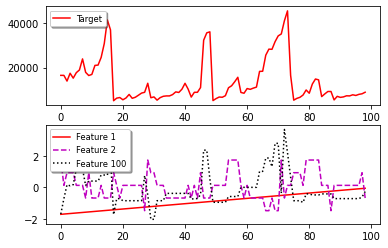

In [6]:
fig, ax = plt.subplots(2, 1)
c=ax[0].plot(y[1:100],'r',label='Target')
l = ax[0].legend(loc='upper left', shadow=True, fontsize='small')

c=ax[1].plot(X[1:100,0],'r',label='Feature 1')
c=ax[1].plot(X[1:100,1],'m--',label='Feature 2')
c=ax[1].plot(X[1:100,2],'k:',label='Feature 100')
legend = ax[1].legend(loc='upper left', shadow=True, fontsize='small')




## Split into training and validation datasets

Training dataset size (153,)
Test dataset size (52,)


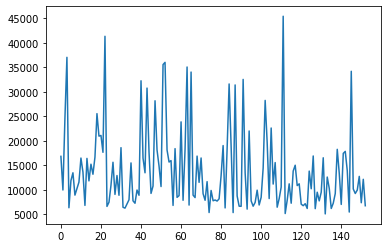

In [7]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=32)
print('Training dataset size',y_train.shape)
print('Test dataset size',y_test.shape)

s=plt.plot(y_train)


## 1.(a) Kernel ridge regression on car prices

We assume that the car prices (y) can be predicted as

$$y = a_0 x_0 + \ldots a_{9} x_{9}+.., $$

where $a_1,..a_{9},..$ are the coefficients and $x_0 .. x_9 ..$ are the home features. If we express the category vector as the weighted linear combination of the other curves, when the model order gets bigger, the demension of the matrix need to be created increases exponentially. For example, in our car price dataset, there are 15 paramaters. With the model order equals to 2, we need to construct $15^2$ terms for linear combination. With the model order equals to 10, we need to construct $15^{10}$ terms.

In order to solve this term-explosion problem, kernel trick can be used where the size of the matrix created only depends on the number of points in the dataset. In our car price dataset case, the number of cars is 153. Therefore, only $153 * 153$ matrix is needed to compute the regression.

To implement the kernel ridge regression, we first create the matrix X_train like we did in HW1, whose columns are the normalized training features. We then define the so-called $kernel\ matrix\ \mathbf K$, of order, $N$:
$$\mathbf K := \begin{bmatrix} \kappa(x_1, x_1) & \ldots & \kappa(x_1, x_N) \\ \vdots & \vdots & \vdots \\ \kappa(x_N, x_1) & \ldots & \kappa(x_N, x_N) \end{bmatrix}$$
where $\kappa(x,y)$ is called the $kernel$.

$kernel$ can be different types, some major ones are but not limited to:

#### Linear Kernel
$$\kappa(x_i, x_j) = x_i^Tx_j$$
#### Polynomial Kernel
$$\kappa(x_i,x_j) = \langle 1 + \langle x_i,x_j \rangle ^d \rangle$$ where $d$ is a paramater you can tune.
#### Gaussian Kernel
$$\kappa(x_i, x_j) = exp(-\frac{\|x_i - x_j\|^2}{2\sigma^2})$$

We will solve for $\mathbf a$ using kernel ridge regression as 

$$\mathbf a = \arg \min_{\mathbf a}\mathbf J(\mathbf a)$$
where $\mathbf J(\mathbf a) = (y - \mathbf K\mathbf a)^T(y - \mathbf K\mathbf a) + \alpha\mathbf a^T\mathbf K^T\mathbf a$ and \alpha is the regularization parameter.

WITHOUT using Scikit learn, construct the kernel matrix $\mathbf K$ seperately with polynomial kernel and gaussian kernel. Compute the coefficients for arbitrary choices of regularization parameter \alpha.

Note that $\hat{\mathbf a} = (\mathbf K + \alpha\mathbf I)^{-1}y$ and $\hat{y}(x) = y^T(\mathbf K + \alpha\mathbf I)^{-1}\kappa(x)$


#### Little helper function to construct polynomial kernel

In [22]:
def polynomialKernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

polynomialKernel([1,2,3], [1,2,3], 2)


def KPolyMatrix(x,y,d): 
  var1 = x.shape[0]
  var2 = y.shape[0]
  KMatrix1= np.zeros((var1,var2))
  for i in range(var1):
    for j in range(var2):
      KMatrix1[i,j] = polynomialKernel(X_train[i],X_train[j],d)
  return(KMatrix1)

def guassianKernel(x,y,sigma):
  constant = 1/np.sqrt(2*np.pi*sigma**2)
  scaleddistance = np.sum(x-y)**2/sigma**2/2
  guassian = constant * np.exp(-scaleddistance)
  return(guassian)


def KGuassMatrix(x,y,d):
  varX = x.shape[0]
  varY = y.shape[0]
  KMatrix2 = np.zeros((varX,varY))
  for i in range (varX):
    for j in range(varY):
      KMatrix2[i,j] = guassianKernel(X_train[i],X_train[j],d)
  return(KMatrix2)


Text(0.5, 1.0, 'Predicted Guassian Kernel Coefficients')

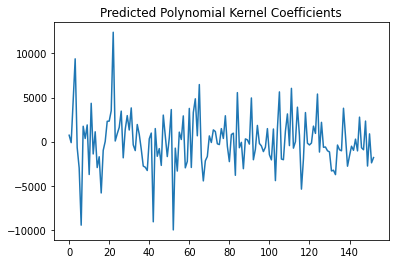

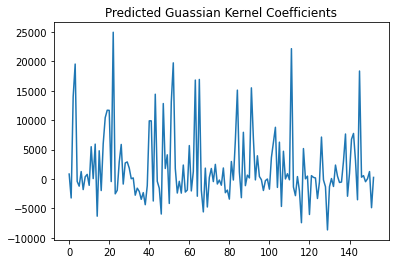

In [51]:

alpha = 1

polyKernel = KPolyMatrix(X_train, X_train,1)
polycoefficients = np.linalg.inv(polyKernel + alpha * np.identity(polyKernel.shape[1])) @ y_train

fig1 = plt.figure()
ax = fig1.gca()
ax.plot(polycoefficients)
plt.title('Predicted Polynomial Kernel Coefficients')

guassKernel = KGuassMatrix(X_train,X_train,1)
guasscoefficients = np.linalg.inv(guassKernel + alpha * np.identity(guassKernel.shape[1])) @ y_train

fig2 = plt.figure()
ax = fig2.gca()
ax.plot(guasscoefficients)
plt.title('Predicted Guassian Kernel Coefficients')



## 1.(a) Prediction

Perform prediction and compare to the actual prices

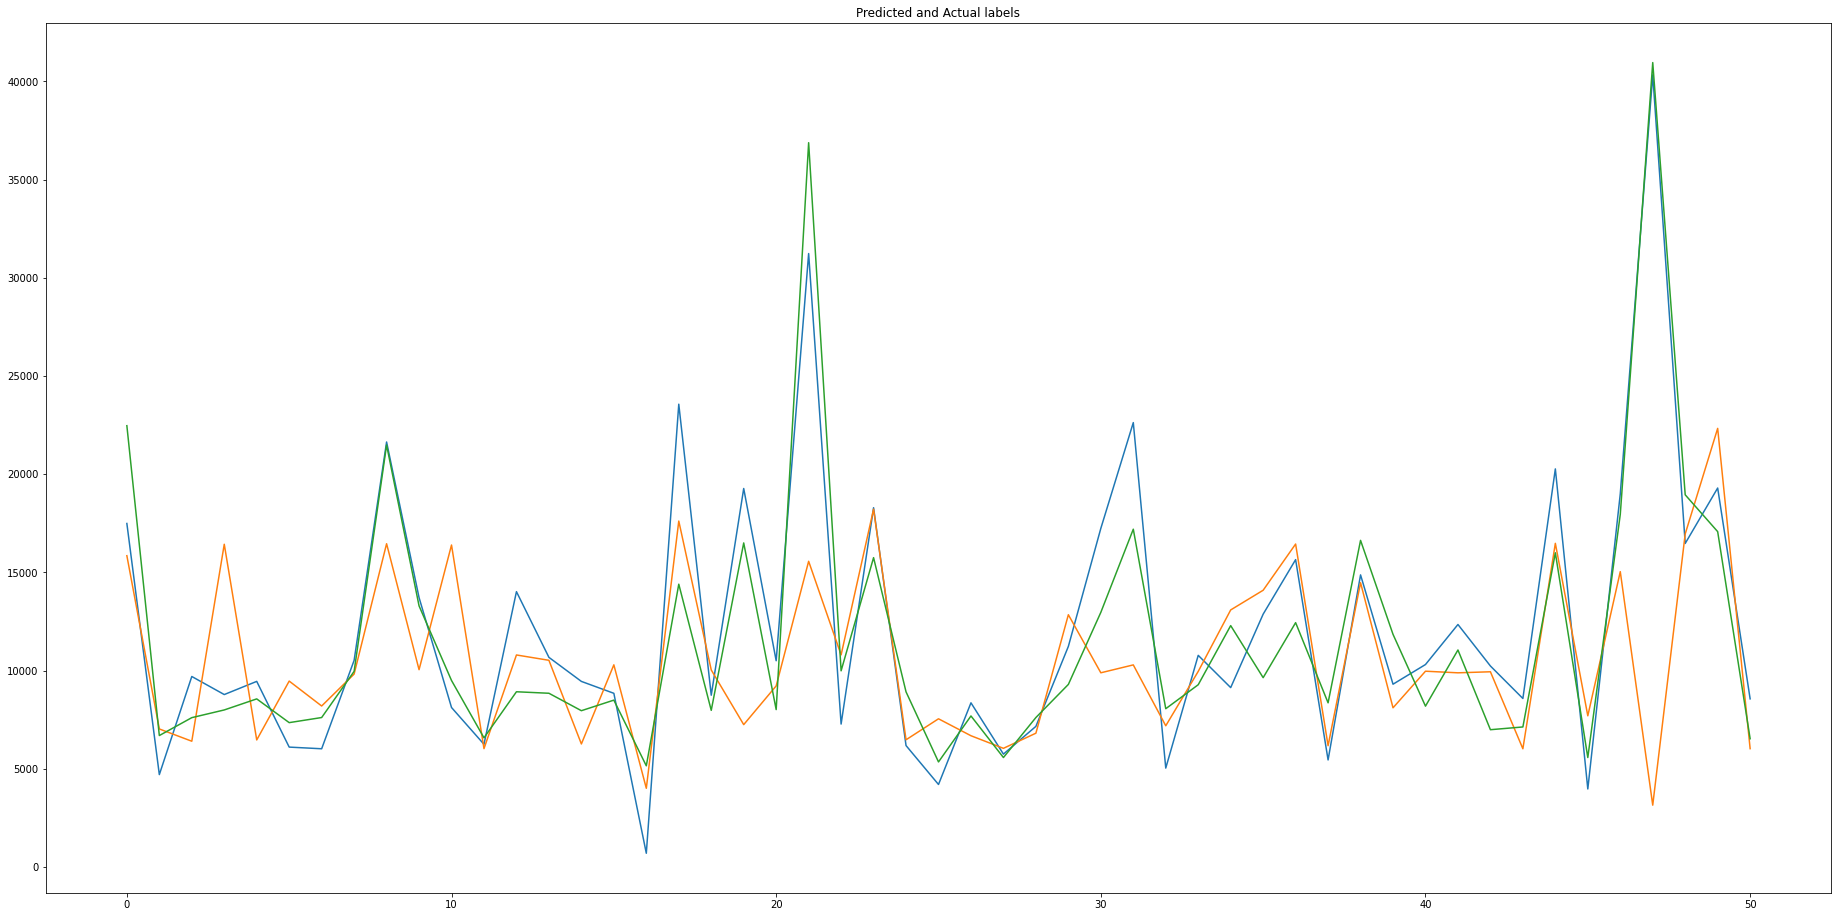

In [58]:
# MODIFY CODE BELOW
KxPoly = np.zeros((52,153))
for i in range(52):
  for j in range(153):
    KxPoly[i,j] = polynomialKernel(X_test[i],X_train[j],1)

prediction1 = polycoefficients.T @ KxPoly.T

KxGuass = np.zeros((52,153))
for i in range(52):
  for j in range(153):
    KxGuass[i,j] = guassianKernel(X_test[i],X_train[j],1)

prediction2 = guasscoefficients.T @ KxGuass.T

fig = plt.figure(figsize=(32,16))
ax = fig.gca()
plt.plot(prediction1[1:100])
plt.plot(prediction2[1:100])

plt.plot(y_test[1:100])

s=plt.title('Predicted and Actual labels')


## 1.(b) Regularization parameter selection; kernel ridge regression using scikit learn

We will now determinee the best regularization parameter, which would hopefully reduce the overfitting issue. We will now use ridge regression from Scikit learn for this purpose. See https://scikit-learn.org/stable/ for documentation. Specifically, the coefficients are learned from training data for different parameters, while the error on the validation data is used to determine the optimal parameter. By thresholding the coefficients, you will select the most significant and least significant predictors. This function also solves

$$\mathbf a = \arg \min_{\mathbf a}\mathbf J(\mathbf a)$$

as with 1.(a).

We will store the coefficients, test error, and training error for a range of regularization parameters (denoted by alpha). Note that with $\alpha>0$, the coefficient values will be pushed closer to zero.

The plot of coefficients vs alpha will show when each of the coeffients become zero. Similarly, we can also observe the trend of the training and validation error

Text(0.5, 1.0, 'Kernel Ridge Regression Coefficients')

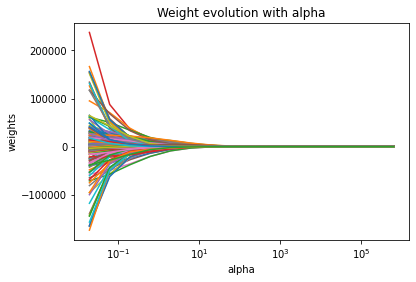

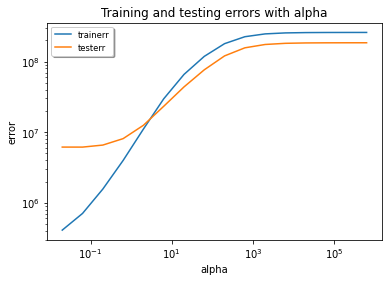

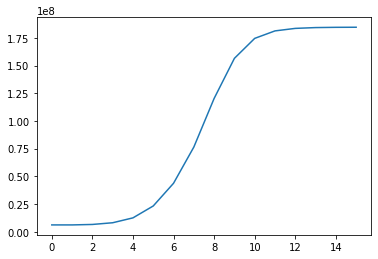

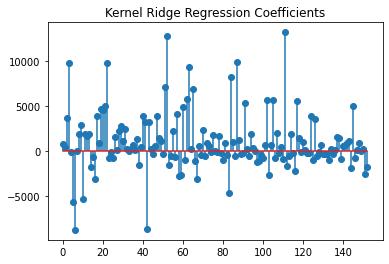

In [59]:
from sklearn.kernel_ridge import KernelRidge
alphas = 10**np.arange(-2,6,0.5)
kernelRidge = KernelRidge(kernel = "rbf")

coefs = []
testerr = []
trainerr = []

for a in alphas:
    kernelRidge.set_params(alpha=a)
    kernelRidge.fit(X_train, y_train)
    coefs.append(kernelRidge.dual_coef_)
    testerr.append(mean_squared_error(y_test, kernelRidge.predict(X_test)))
    trainerr.append(mean_squared_error(y_train, kernelRidge.predict(X_train)))

fig1 = plt.figure()
ax = fig1.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Weight evolution with alpha')

fig2 = plt.figure()
ax2 = fig2.gca()
ax2.plot(alphas*2, trainerr,label='trainerr')
ax2.plot(alphas*2, testerr,label='testerr')
ax2.set_xscale('log')
ax2.set_yscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('error')
legend = ax2.legend(loc='upper left', shadow=True, fontsize='small')
plt.title('Training and testing errors with alpha')


fig3 = plt.figure()
plt.plot(testerr)

# Plot the minimum point in the testing error
fig4 = plt.figure()
plt.stem(coefs[:][4],use_line_collection=True)
plt.title('Kernel Ridge Regression Coefficients')

## 1.(c) Use the polynomial kernel to compute the kernel ridge regression and plot the prediction
In this section, we will compute the kernel ridge regression with scikit-learn using polynomial kernel. Please plot the prediction and compare the prediction with the actual prices. (Similar to 1.(a) Prediction)

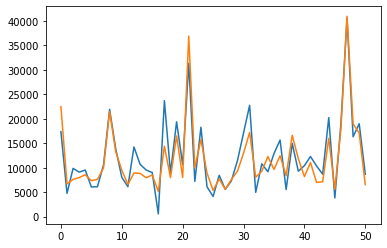

In [67]:
min_validation_error_index = np.where(testerr == np.min(testerr))
min_validation_error = alphas[min_validation_error_index][0]
alpha = min_validation_error

pMatrix = np.zeros((52,153))
for i in range(52):
  for j in range(153):
    pMatrix[i,j] = polynomialKernel(X_test[i],X_train[j],1)



polyCoef = np.linalg.inv(polyKernel + alpha * np.eye(X_train.shape[0])) @ y_train
polyPrediction = polyCoef.T @ pMatrix.T


fig = plt.figure()
ax=fig.gca()
plt.plot(polyPrediction[1:100])

plt.plot(y_test[1:100])

## 1.(d) Use the gaussian kernel to compute the kernel ridge regression and plot the prediction
Similar to what we did in the previous section, let's compute the kernel ridge regression with scikit-learn using gaussian kernel. Please plot the prediction and compare the prediction with the actual prices. (Similar to 1.(a) Prediction)

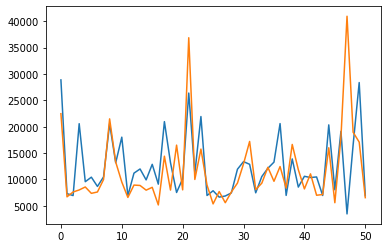

In [66]:
min_validation_error_index = np.where(testerr == np.min(testerr))
min_validation_error = alphas[min_validation_error_index][0]
alpha = min_validation_error

gMatrix = np.zeros((52,153))
for i in range(52):
  for j in range(153):
    gMatrix[i,j] = guassianKernel(X_test[i],X_train[j],1)



guassCoef = np.linalg.inv(guassKernel + alpha * np.eye(X_train.shape[0])) @ y_train
gaussPrediction = guassCoef.T @ gMatrix.T


fig = plt.figure()
ax=fig.gca()
plt.plot(gaussPrediction[1:100])

plt.plot(y_test[1:100])